## Librerias


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2


import warnings
warnings.filterwarnings("ignore")

## Funciones


In [2]:
def resumen_cant_porcentaje(df, columna):
    # Cuanta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

In [3]:
def calcula_rating(row):
    if row["sentiment_analysis"] == 0 and not row["reviews_recommend"]:
        return 1
    elif row["sentiment_analysis"] == 0 and row["reviews_recommend"]:
        return 1
    elif row["sentiment_analysis"] == 1 and not row["reviews_recommend"]:
        return 2
    elif row["sentiment_analysis"] == 1 and row["reviews_recommend"]:
        return 3
    elif row["sentiment_analysis"] == 2 and not row["reviews_recommend"]:
        return 4
    elif row["sentiment_analysis"] == 2 and row["reviews_recommend"]:
        return 5
    else:
        return None

In [4]:
def verificar_tipo_datos(df):

    #Se crea un diccionario (mi_dict) con cinco claves: "nombre_campo", "tipo_datos", "no_nulos_%", "nulos_%", y "nulos". Estas claves se utilizarán para almacenar información sobre cada columna del DataFrame.
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    #Se realiza un bucle sobre todas las columnas del DataFrame df.
    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].apply(type).unique())
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100-porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

        # Se calcula el porcentaje de valores no nulos en la columna actual (porcentaje_no_nulos).
        # La columna actual se agrega a la lista bajo la clave "nombre_campo".
        # Se obtiene el tipo de datos único en la columna actual y se agrega a la lista bajo la clave "tipo_datos".
        # Se agrega el porcentaje de valores no nulos a la lista bajo la clave "no_nulos_%".
        # Se agrega el porcentaje de valores nulos a la lista bajo la clave "nulos_%".
        # Se agrega la cantidad de valores nulos en la columna actual a la lista bajo la clave "nulos".

    # Se utiliza el diccionario mi_dict para crear un nuevo DataFrame llamado df_info.
    df_info = pd.DataFrame(mi_dict)

    # La función devuelve el DataFrame df_info que contiene información sobre cada columna, incluidos el nombre de la columna, el tipo de datos, el porcentaje de valores no nulos, el porcentaje de valores nulos y la cantidad de valores nulos.
    return df_info

## Preparación de los datos para el modelo

El objetivo del modelo de recomendación es generar una lista de 5 juegos al proporcionar el nombre de un juego o el ID de un usuario. Esta recomendación se basa en un puntaje que debe ser determinado. Para lograr esto, se examinan los dataframes df_reviews y df_items, los cuales fueron analizados previamente.

In [5]:
df_reviews = pd.read_csv('/content/drive/MyDrive/HENRY/2_Dataset_limpio/Australian_user_reviews_limpio.csv', encoding='utf-8')
df_items = pd.read_csv('/content/drive/MyDrive/HENRY/2_Dataset_limpio/Australian_users_items_limpio.csv', encoding='utf-8')

In [6]:
df_reviews.sample(5)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis
3121,76561198072798256,http://steamcommunity.com/profiles/76561198072...,570.0,3 of 3 people (100%) found this review helpful,True,2014-06-21,1
16412,MrMeDisaster,http://steamcommunity.com/id/MrMeDisaster,238460.0,5 of 6 people (83%) found this review helpful,True,2014-06-28,1
19821,76561198048309884,http://steamcommunity.com/profiles/76561198048...,730.0,1 of 1 people (100%) found this review helpful,True,2015-06-15,1
33511,76561198013255974,http://steamcommunity.com/profiles/76561198013...,25890.0,No ratings yet,True,2014-01-04,1
47813,Zejus,http://steamcommunity.com/id/Zejus,200210.0,1 of 5 people (20%) found this review helpful,True,2014-01-17,1


In [7]:
df_items.sample(5)

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
2205649,381120,Shoppe Keep,0,76561198071677972,397,76561198071677972,http://steamcommunity.com/profiles/76561198071...
351425,398110,Reigning Cats,160,76561198102767019,7762,phrostb,http://steamcommunity.com/id/phrostb
463037,31280,Poker Night at the Inventory,162,76561198088617212,118,76561198088617212,http://steamcommunity.com/profiles/76561198088...
1835270,205230,Hell Yeah!,0,76561198063100139,306,76561198063100139,http://steamcommunity.com/profiles/76561198063...
2878027,4560,Company of Heroes,9,76561198054929123,81,eugeniolopstar,http://steamcommunity.com/id/eugeniolopstar


Se decide crear un puntaje (rating) para los juegos utilizando el análisis de sentimiento de las reviews y las recomendaciones de los usuarios. El análisis de sentimiento se clasifica como 0 (negativo), 1 (neutral) y 2 (positivo), mientras que las recomendaciones son True (recomienda el juego) y False (no lo recomienda). El puntaje varía de 1 a 5, donde 1 indica un juego no recomendado con reviews negativas, y 5 indica un juego recomendado con reviews positivas. La escala se determina considerando la combinación de ambas variables de la siguiente manera:

* 1: Sentimiento negativo, ya sea recomendado o no.
* 2: Sentimiento neutral y no recomendado.
* 3: Sentimiento neutral y recomendado.
* 4: Sentimiento positivo y no recomendado.
* 5: Sentimiento positivo y recomendado.


En el df `df_reviews`creamos una columna nueva llamada `rating`

In [8]:
df_reviews['rating'] = df_reviews.apply(calcula_rating, axis=1)
df_reviews.sample(5)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis,rating
32766,MAXFAX28,http://steamcommunity.com/id/MAXFAX28,369580.0,36 of 95 people (38%) found this review helpful,False,2015-07-03,1,2
20440,76561198057201323,http://steamcommunity.com/profiles/76561198057...,230410.0,No ratings yet,True,2014-11-28,2,5
24445,76561198098029716,http://steamcommunity.com/profiles/76561198098...,113400.0,No ratings yet,True,2014-01-30,1,3
42262,76561198059346705,http://steamcommunity.com/profiles/76561198059...,349480.0,No ratings yet,False,2015-09-04,1,2
17852,76561198075583182,http://steamcommunity.com/profiles/76561198075...,49520.0,1 of 1 people (100%) found this review helpful,True,2014-02-11,1,3


Se crea un nuevo dataframe dejando solo las columnas 'user_id', 'reviews_item_id' y 'rating' y se reserva.

In [9]:
df1 = df_reviews[['user_id', 'reviews_item_id', 'rating']]
df1.head(2)

,user_id,reviews_item_id,rating
0,76561197970982479,1250.0,3
1,js41637,251610.0,3


Se crea otro df que contenga unicamente los 'item_id' y los nombres de los juego.

In [10]:
df2 = df_items[['item_id', 'item_name']]
# Se borran los dumplicados
df2 = df2.drop_duplicates()
# Cantidad de juegos
print(f'Hay un total de {len(df2)} juegos')
df2.head(2)

Hay un total de 10978 juegos


,item_id,item_name
0,10,Counter-Strike
1,20,Team Fortress Classic


Luego se agregan los nombres de los juegos al primer dataframe.

In [11]:
df = df1.merge(df2, left_on="reviews_item_id", right_on="item_id", how='left')
df

,user_id,reviews_item_id,rating,item_id,item_name
0,76561197970982479,1250.0,3,1250.0,Killing Floor
1,js41637,251610.0,3,251610.0,Barbie™ Dreamhouse Party™
2,evcentric,248820.0,5,248820.0,Risk of Rain
3,doctr,250320.0,5,250320.0,The Wolf Among Us
4,maplemage,211420.0,3,211420.0,Dark Souls: Prepare to Die Edition
...,...,...,...,...,...
57370,How51,440.0,3,NaN,NaN
57371,76561198111410893,304930.0,3,304930.0,Unturned
57372,zaza147,265630.0,5,265630.0,Fistful of Frags
57373,lifeonhigh,304050.0,3,304050.0,Trove


Se pueden observar algunos juegos a los cuales los usuarios les hicieron comentarios, pero que no estan en el dataframe `df_reviews`. Se verifican los tipos de datos y la cantidad de nulos y luego se revisan las filas con nulos.

In [12]:
verificar_tipo_datos(df)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,user_id,"[<class 'str'>, <class 'float'>]",100.00,0.00,1
1,reviews_item_id,[<class 'float'>],99.99,0.01,8
2,rating,[<class 'int'>],100.00,0.00,0
3,item_id,[<class 'float'>],88.96,11.04,6336
4,item_name,"[<class 'str'>, <class 'float'>]",88.96,11.04,6336


In [13]:
# se revisan los reviews sin nombres de juegos en `df_items`
sin_juegos = df[df.isnull().any(axis=1)]
# Se calculan la cantidad de juegos en esta situación
print(f"Hay un total de {len(sin_juegos['reviews_item_id'].unique())} juegos con reviews pero que no estan en `df_reviews`")
sin_juegos

Hay un total de 355 juegos con reviews pero que no estan en `df_reviews`


,user_id,reviews_item_id,rating,item_id,item_name
10,76561198077246154,440.0,3,NaN,NaN
19,devvonst,440.0,5,NaN,NaN
28,76561198076909484,570.0,1,NaN,NaN
36,boydeer,440.0,3,NaN,NaN
43,jarrodtrim,440.0,5,NaN,NaN
...,...,...,...,...,...
57331,ViniReaper,440.0,5,NaN,NaN
57354,BlinkV1,440.0,3,NaN,NaN
57361,76561198095035915,440.0,1,NaN,NaN
57370,How51,440.0,3,NaN,NaN


Se decide borrarlos del conjunto de datos.

In [14]:
# Se borran los nulos
df = df.dropna(subset=['item_id'])
# Se cuentan los registros que quedan
print(f'Quedan {df.shape[0]} registros')
# Se verifican los tipo de dato y nulos
verificar_tipo_datos(df)

Quedan 51039 registros


,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,reviews_item_id,[<class 'float'>],100.0,0.0,0
2,rating,[<class 'int'>],100.0,0.0,0
3,item_id,[<class 'float'>],100.0,0.0,0
4,item_name,[<class 'str'>],100.0,0.0,0


Se convierte en entero la columna 'item_id' y se crea un último dataframe con las columnas necesarias para los modelos de recomendación.

In [15]:
df = df[['user_id', 'item_name', 'rating']]
df.head(3)

,user_id,item_name,rating
0,76561197970982479,Killing Floor,3
1,js41637,Barbie™ Dreamhouse Party™,3
2,evcentric,Risk of Rain,5


En el siguiente gráfico se pueden ver la cantidad de reviews distribuidos por el puntaje adoptado.

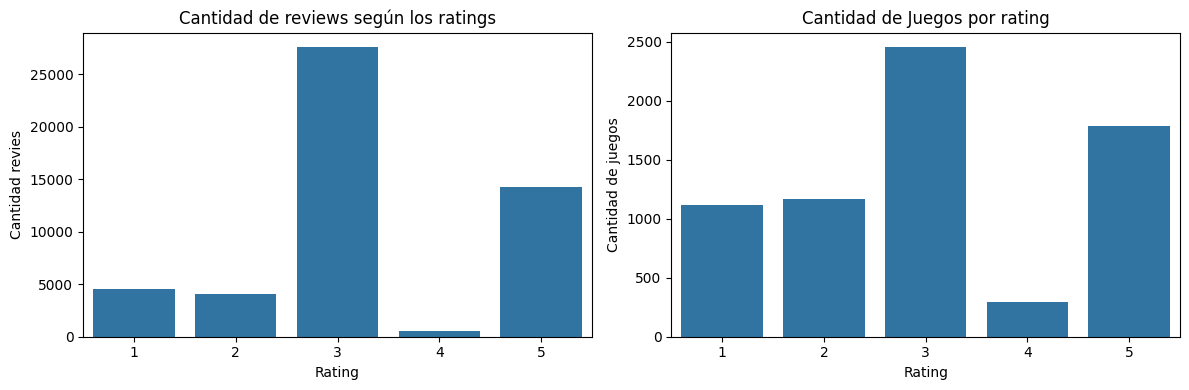

In [16]:
# Agrupa las calificaciones por rating
ratings_count = df['rating'].value_counts().reset_index()
ratings_count.columns = ['rating', 'count']
# Agrupa los juegos únicos por rating
unique_games_per_rating = df.groupby('rating')['item_name'].nunique().reset_index()

# Crea una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Primer subplot
sns.barplot(data=ratings_count, x='rating', y='count', ax=axes[0])
axes[0].set_title('Cantidad de reviews según los ratings') ; axes[0].set_xlabel('Rating') ; axes[0].set_ylabel('Cantidad revies')

# Segundo subplot
sns.barplot(data=unique_games_per_rating, x='rating', y='item_name', ax=axes[1])
axes[1].set_title('Cantidad de Juegos por rating') ; axes[1].set_xlabel('Rating') ; axes[1].set_ylabel('Cantidad de juegos')

# Ajusta y muestra los graficos
plt.tight_layout()
plt.show()

In [17]:
# Cantidades de review por rating
resumen_cant_porcentaje(df, 'rating')

,Cantidad,Porcentaje
3,27559,54.00
5,14239,27.90
1,4585,8.98
2,4103,8.04
4,553,1.08


In [18]:
# Cantidades de juegos por rating
unique_games_per_rating

,rating,item_name
0,1,1114
1,2,1168
2,3,2451
3,4,292
4,5,1788


En el gráfico izquierdo, se aprecia que la mayoría de las evaluaciones muestran un 'rating' de 3, indicativo de sentimientos neutrales pero con recomendación para el juego; esto abarca 27,581 revisiones, representando el 54% de los comentarios. Le siguen 14,237 revisiones con sentimientos positivos que también recomiendan los juegos mencionados. Por último, se identifican menos de 6,000 comentarios con sentimientos negativos. En cuanto al gráfico de la derecha, se visualizan aproximadamente 1,800 juegos recomendados.

Concluyendo, el dataframe necesario para el modelo de recomendación se guarda finalmente.

In [20]:
df.to_csv('/content/drive/MyDrive/HENRY/6_Modelo_recomendacion/df_recomendacion.csv', index=False, encoding='utf-8')
print(f"Se guardado como 'df_recomendacion.csv'")

Se guardado como 'df_recomendacion.csv'


In [21]:
# Cargar el archivo CSV en un DataFrame
df = pd.read_csv('/content/drive/MyDrive/HENRY/6_Modelo_recomendacion/df_recomendacion.csv')

# Especificar la ruta del archivo Parquet de salida
archivo_parquet = '/content/drive/MyDrive/HENRY/6_Modelo_recomendacion/df_recomendacion.parquet'

# Guardar el DataFrame en formato Parquet
df.to_parquet(archivo_parquet, index=False)

print(f'Archivo Parquet guardado en: {archivo_parquet}')

Archivo Parquet guardado en: /content/drive/MyDrive/HENRY/6_Modelo_recomendacion/df_recomendacion.parquet
